# LSTM for Time series prediction

What LSTM solves: Given the last few `n` samples of data in time, predict the next few `m` samples of data.

See https://colah.github.io/posts/2015-08-Understanding-LSTMs/ for more information about LSTMs. 

## Prelude

Import all the packages.

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import collections

# Part A. Data processing

## Import dataset

Import dataset into a pandas DataFrame.

`dataset.csv` is the Birmingham carpark dataset and should exist in the jupyter notebook directory.
Get it from https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham

In [2]:
def import_dataset():
    with open('dataset.csv', 'r') as f:
        x = f.read().strip().split('\n')
    y = [x.split(',') for x in x]
    y = y[1:]  # First line is header
    SystemCodeNumber, Capacity, Occupancy, LastUpdated = zip(*y)
    Capacity = pd.to_numeric(Capacity)
    Occupancy = pd.to_numeric(Occupancy)
    LastUpdated = pd.to_datetime(LastUpdated)
    return pd.DataFrame({'SystemCodeNumber': SystemCodeNumber, 'Capacity': Capacity, 'Occupancy': Occupancy}, index=LastUpdated)

ds_import = import_dataset()
ds_import

,Capacity,Occupancy,SystemCodeNumber
2016-10-04 07:59:42,577,61,BHMBCCMKT01
2016-10-04 08:25:42,577,64,BHMBCCMKT01
2016-10-04 08:59:42,577,80,BHMBCCMKT01
2016-10-04 09:32:46,577,107,BHMBCCMKT01
2016-10-04 09:59:48,577,150,BHMBCCMKT01
2016-10-04 10:26:49,577,177,BHMBCCMKT01
2016-10-04 10:59:48,577,219,BHMBCCMKT01
2016-10-04 11:25:47,577,247,BHMBCCMKT01
2016-10-04 11:59:44,577,259,BHMBCCMKT01
2016-10-04 12:29:45,577,266,BHMBCCMKT01


## Split dataset into different carparks

At the same time, determine their capacity.

In [3]:
def split_into_carparks(dataset):
    "Output: { carpark_name: (dataset, capacity) }"
    carparks = dataset['SystemCodeNumber'].unique()
    out = {}
    for carpark in carparks:
        x = dataset.loc[dataset['SystemCodeNumber'] == carpark]
        capacity = x['Capacity'].iloc[0]
        assert x[x['Capacity'] != capacity].shape[0] == 0, 'Capacity is not the same for all rows!'
        out[carpark] = x['Occupancy'], capacity
    return out

ds_split = split_into_carparks(ds_import)
ds_split

{'BHMBCCMKT01': (2016-10-04 07:59:42     61
  2016-10-04 08:25:42     64
  2016-10-04 08:59:42     80
  2016-10-04 09:32:46    107
  2016-10-04 09:59:48    150
  2016-10-04 10:26:49    177
  2016-10-04 10:59:48    219
  2016-10-04 11:25:47    247
  2016-10-04 11:59:44    259
  2016-10-04 12:29:45    266
  2016-10-04 13:02:48    269
  2016-10-04 13:29:45    263
  2016-10-04 14:02:47    238
  2016-10-04 14:29:49    215
  2016-10-04 14:57:13    192
  2016-10-04 15:30:14    165
  2016-10-04 16:04:12    162
  2016-10-04 16:31:14    143
  2016-10-05 07:57:17     54
  2016-10-05 08:30:15     59
  2016-10-05 09:04:19     71
  2016-10-05 09:30:15     83
  2016-10-05 10:04:15    114
  2016-10-05 10:30:17    128
  2016-10-05 11:04:19    148
  2016-10-05 11:30:18    162
  2016-10-05 12:04:14    178
  2016-10-05 12:30:16    183
  2016-10-05 12:57:15    175
  2016-10-05 13:30:19    179
                        ... 
  2016-12-18 11:03:25     89
  2016-12-18 11:30:22    135
  2016-12-18 12:03:23    165

## Resample data

The Birmingham carpark dataset is updated every 30min from 8am to 5pm. However, the dataset doesn't actually contain samples at exactly 30min intervals. (e.g. first sample is taken at `2016-10-04 07:59:42`, and second sample is taken at `2016-10-04 07:59:42`). Furthermore, data is sometimes entirely missing for certain times.

We want the timings for each sample to be precisely at 8am, 8.30am, 9am, 9.30am etc. To do that we first upsample the dataset to 1min interval, then interpolate over missing data, and then downsample it down to 30min intervals. Set limit to 60 because we don't want to over-interpolate and fill in up to 1hr worth of junk data.

In [4]:
def resample_data(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.resample('1T').mean().interpolate(method='time',limit_direction='both', limit=60).resample('30T').mean().astype(np.float32), capacity
    return out

ds_resample = resample_data(ds_split)
ds_resample

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00           NaN
  2016-10-04 18:30:00           NaN
  2016-10-04 19:00:00           NaN
  2016-10-04 19:30:00           NaN
  2016-10-04 20:00:00           NaN
  2016-10-04 20:30:00           NaN
  2016-10-04 

## Which carparks are missing too much data?

Some carparks are missing too much data to be usable.
Find out what they are by counting what percentage of their data between 8am to 5pm are `NaN`s.

In [5]:
def get_missing_data_percent(dataset):
    out = []
    for (k, (v, capacity)) in dataset.items():
        x = v.between_time('08:00', '17:00')
        out.append((x[x.isnull()].shape[0] / float(x.shape[0]) * 100, k))
    return out

print('\n'.join(repr(x) for x in sorted(get_missing_data_percent(ds_resample))))

(5.266757865937072, 'BHMBCCMKT01')
(5.266757865937072, 'BHMBCCTHL01')
(5.266757865937072, 'BHMEURBRD01')
(5.266757865937072, 'BHMMBMMBX01')
(5.266757865937072, 'BHMNCPNST01')
(5.266757865937072, 'Broad Street')
(5.266757865937072, 'Others-CCCPS105a')
(5.266757865937072, 'Others-CCCPS119a')
(5.266757865937072, 'Others-CCCPS135a')
(5.266757865937072, 'Others-CCCPS202')
(5.266757865937072, 'Others-CCCPS8')
(5.266757865937072, 'Others-CCCPS98')
(5.266757865937072, 'Shopping')
(5.403556771545827, 'BHMNCPHST01')
(6.566347469220246, 'BHMBCCSNH01')
(6.566347469220246, 'BHMNCPLDH01')
(6.566347469220246, 'Others-CCCPS133')
(6.6347469220246245, 'BHMNCPPLS01')
(7.865937072503421, 'BHMBCCPST01')
(7.865937072503421, 'BHMEURBRD02')
(9.537366548042705, 'NIA Car Parks')
(9.537366548042705, 'NIA South')
(14.36388508891929, 'BHMBRCBRG01')
(14.36388508891929, 'BHMBRCBRG02')
(14.36388508891929, 'BHMBRCBRG03')
(14.36388508891929, 'Bull Ring')
(14.432284541723666, 'BHMNCPRAN01')
(16.8141592920354, 'BHMBRTARC

## Remove carparks missing too much data

For (hopefully) good results, we remove carparks that have above 6% NANs.

In [6]:
def remove_bad_datasets(dataset, crit=6):
    out = {}
    for p, k in get_missing_data_percent(dataset):
        if p >= crit:
            continue
        out[k] = dataset[k]
    return out

ds_badrm = remove_bad_datasets(ds_resample)
ds_badrm

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00           NaN
  2016-10-04 18:30:00           NaN
  2016-10-04 19:00:00           NaN
  2016-10-04 19:30:00           NaN
  2016-10-04 20:00:00           NaN
  2016-10-04 20:30:00           NaN
  2016-10-04 

## Finally fill in all missing data

Finally, use interpolation to fill in all missing data.
This includes the timings for which data does not simply exist (5pm to 8am).

In [7]:
def fill_in_missing_data(dataset):
    out = {}
    for k, (v, capacity) in dataset.items():
        out[k] = v.interpolate(method='linear'), capacity
    return out

ds_filled = fill_in_missing_data(ds_badrm)
dataset = ds_filled
ds_filled

{'BHMBCCMKT01': (2016-10-04 07:30:00     61.000000
  2016-10-04 08:00:00     62.906864
  2016-10-04 08:30:00     73.176468
  2016-10-04 09:00:00     92.681816
  2016-10-04 09:30:00    126.984848
  2016-10-04 10:00:00    165.554550
  2016-10-04 10:30:00    200.545456
  2016-10-04 11:00:00    235.450974
  2016-10-04 11:30:00    253.882355
  2016-10-04 12:00:00    262.616669
  2016-10-04 12:30:00    267.409088
  2016-10-04 13:00:00    266.190918
  2016-10-04 13:30:00    251.257568
  2016-10-04 14:00:00    227.342422
  2016-10-04 14:30:00    202.268188
  2016-10-04 15:00:00    177.681824
  2016-10-04 15:30:00    163.720581
  2016-10-04 16:00:00    154.405960
  2016-10-04 16:30:00    141.722733
  2016-10-04 17:00:00    138.819107
  2016-10-04 17:30:00    137.281311
  2016-10-04 18:00:00    134.296280
  2016-10-04 18:30:00    131.311264
  2016-10-04 19:00:00    128.326233
  2016-10-04 19:30:00    125.341209
  2016-10-04 20:00:00    122.356178
  2016-10-04 20:30:00    119.371155
  2016-10-04 

## Plot the data

Finally, plot the data to get a sense of all the data.

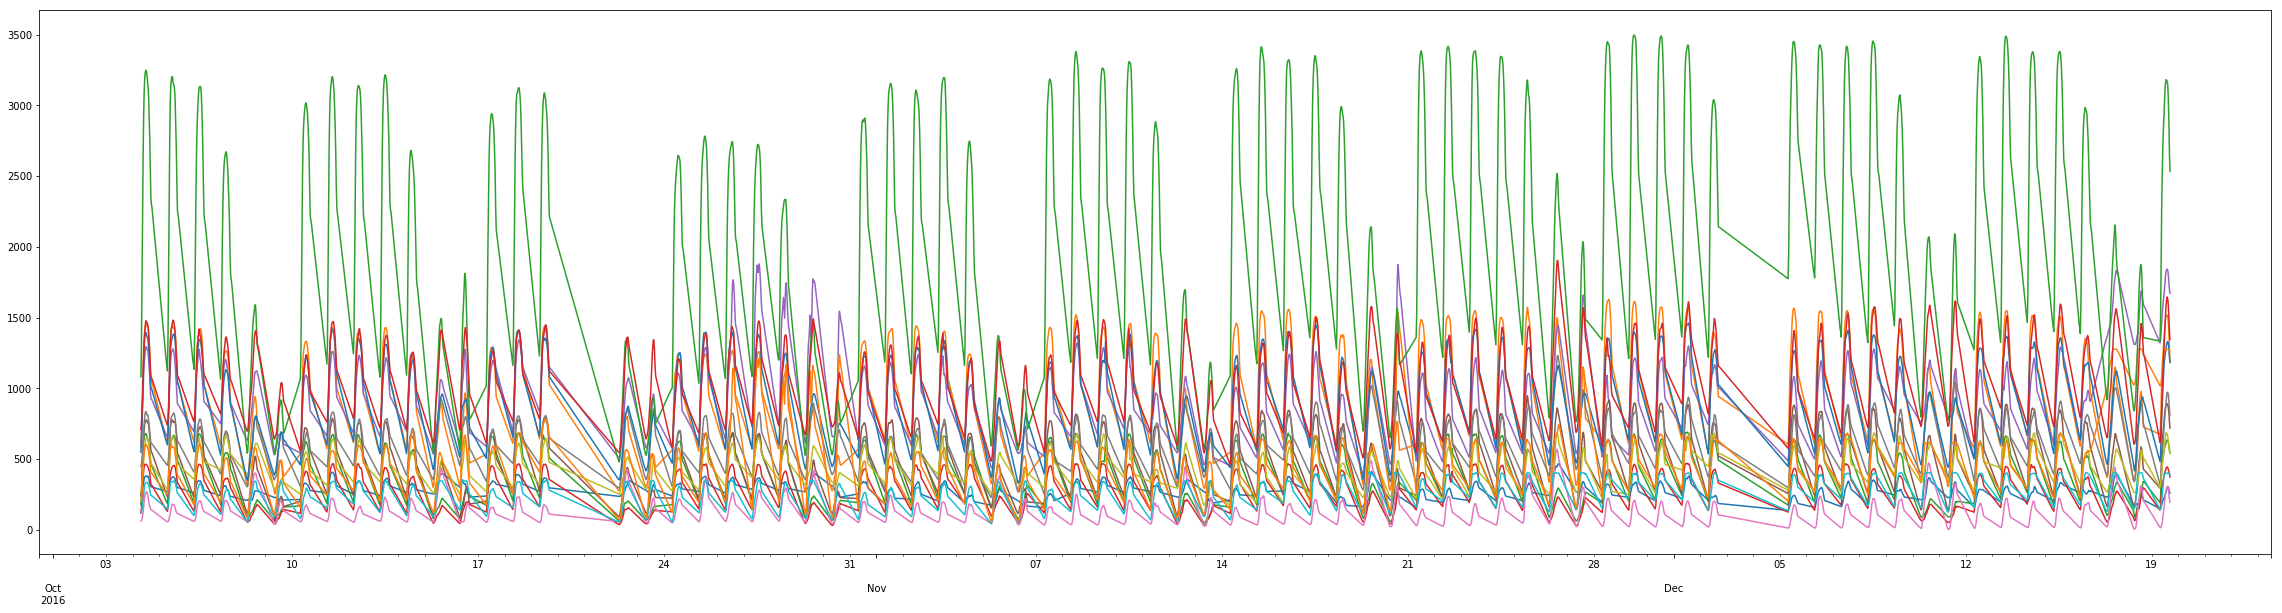

In [8]:
for k, (v, capacity) in ds_filled.items():
    v.plot(figsize=(40, 10))

# Part B. Machine Learning

## `split_by_week()` -- Training/Validation set split helper function

For training and validation, we first split carpark data into *weeks*. The specified number of weeks will be used for validation, and the other weeks are used for training.

In [9]:
def split_by_week(dataset, validation_size=2):
    """
    Input: (DataFrame, capacity)
    Output: (DataFrame for training, DataFrame for validation, capacity)
    """
    v, _ = dataset
    groups = list(d for _, d in v.groupby(v.index.weekofyear))
    return (pd.concat(groups[:-validation_size]), pd.concat(groups[-validation_size:]), capacity)

## `genslide()` -- Sliding window construction helper function

LSTM works by passing it `t - 1`, `t - 2`, `t - n` past data elements, and then asking it to predict `t`, `t + 1` ... `t + m - 1`.
To do this we need a helper function to generate a sliding window of `n + m` elements over the data.

In [10]:
def genslide(data, n, m):
    """input: numpy array with shape (numrows, numcols)
    output: (inputs, targets), where inputs is a numpy array with shape (numrows - (n + m) + 1, n, numcols)
    and targets is a numpy array with shape (numrows - (n + m) + 1, m * numcols)
    Notice for targets that the last two shape components are flattened.
    """
    assert data.ndim == 2 or data.ndim == 1, "input must be numpy array with shape (numrows, numcols). ndim is {0}".format(data.ndim)
    if data.ndim == 1:
        data = data.reshape(data.shape[0], 1)
    numrows, numcols = data.shape
    outrows = max(numrows - (n + m) + 1, 0)
    out_inputs = np.empty((outrows, n, numcols), dtype=np.float32)
    out_targets = np.empty((outrows, m, numcols), dtype=np.float32)
    for i in range(0, outrows):
        out_inputs[i] = data[i:i+n]
        out_targets[i] = data[i+n:i+n+m]
    out_targets = out_targets.reshape(outrows, m * numcols)
    assert out_inputs.shape == (outrows, n, numcols)
    assert out_targets.shape == (outrows, m * numcols)
    return out_inputs, out_targets

## `train_model()` -- Model setup and training helper function

We use mean squared error as the error measure.

In [11]:
def train_model(data, n, m, num_lstm_layers, hidden_size, batch_size, epochs):
    """
    data: Pandas DataFrame containing the training carpark data.
    n: Number of past data points
    m: Number of output data points to predict
    hidden_size: The number of LSTM units
    """
    data_inputs, data_targets = genslide(data.values, n, m)
    assert data_inputs.ndim == 3
    assert data_targets.ndim == 2
    seqs = []
    lstmLayerType = tf.keras.layers.CuDNNLSTM if tf.test.is_gpu_available(cuda_only=True) else tf.keras.layers.LSTM
    for i in range(num_lstm_layers):
        seqs.append(lstmLayerType(hidden_size, return_sequences=(i != num_lstm_layers - 1)))
    seqs.append(tf.keras.layers.Dense(data_targets.shape[1]))
    model = tf.keras.Sequential(seqs)
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    model.fit(data_inputs, data_targets, batch_size=batch_size, epochs=epochs)
    return model

## `evaluate_model()` -- Helper function for evaluating model by calculating mean squared error

In [12]:
def evaluate_model(model, data, n, m, batch_size):
    """
    model: Trained model
    data: Pandas dataframe containing carpark data for evaluation
    Returns: (np.float64) mean squared error
    """
    data_inputs, data_targets = genslide(data.values, n, m)
    assert data_inputs.ndim == 3
    assert data_targets.ndim == 2
    return model.evaluate(data_inputs, data_targets, batch_size=batch_size)

## `evaluate_model_plot()` -- Helper function for evaluating model by plotting predicted + actual on graph

In [13]:
def evaluate_model_plot(model, data, n, m):
    data_inputs, data_targets = genslide(data.values, n, m)
    _, _, numcols = data_inputs.shape
    out_data = []
    out_indexes = []
    for i, (inp, tgt) in enumerate(zip(data_inputs, data_targets)):
        out_indexes.extend(data.index[i + n + z] for z in range(m))
        inp = inp.reshape(1, *inp.shape)
        vals = model.predict(inp)
        vals = vals.reshape(m, numcols)
        out_data.extend(vals)
    df = pd.DataFrame(out_data, index=out_indexes)
    ax = df.plot(style='.', label='Predicated', figsize=(40, 20))
    data.plot(ax=ax, style='+', label='Actual')
    ax.legend()

## Example: Training and Evaluation on Carpark BHMBCCMKT01

As an example of putting all the functions above, we train a model on carpark BHMBCCMKT01 and evaluate it by calculating its mean squared error on the validation set and also plotting it graphically.

In [14]:
data = dataset['BHMBCCMKT01']
n, m = 10, 2  # Predict 1 hour ahead using 5 hours worth of past data
train_set, eval_set, capacity = split_by_week(data, validation_size=2)
model = train_model(train_set, n, m,
                    num_lstm_layers=2,
                    hidden_size=200,
                    batch_size=4,
                    epochs=13)

Epoch 1/13
3286/3286 [==============================] - 8s 2ms/step - loss: 9591.3328
Epoch 2/13
3286/3286 [==============================] - 6s 2ms/step - loss: 2602.6931
Epoch 3/13
3286/3286 [==============================] - 6s 2ms/step - loss: 1171.0987
Epoch 4/13
3286/3286 [==============================] - 6s 2ms/step - loss: 624.7481
Epoch 5/13
3286/3286 [==============================] - 6s 2ms/step - loss: 383.7486
Epoch 6/13
3286/3286 [==============================] - 6s 2ms/step - loss: 295.6409
Epoch 7/13
3286/3286 [==============================] - 6s 2ms/step - loss: 228.2980
Epoch 8/13
3286/3286 [==============================] - 6s 2ms/step - loss: 186.5809
Epoch 9/13
3286/3286 [==============================] - 6s 2ms/step - loss: 161.6830
Epoch 10/13
3286/3286 [==============================] - 6s 2ms/step - loss: 151.0048
Epoch 11/13
3286/3286 [==============================] - 6s 2ms/step - loss: 153.8321
Epoch 12/13
3286/3286 [==============================] - 6s 

In [15]:
evaluate_model(model, eval_set, n, m, batch_size=4)

359/359 [==============================] - 0s 1ms/step


117.31443384962162

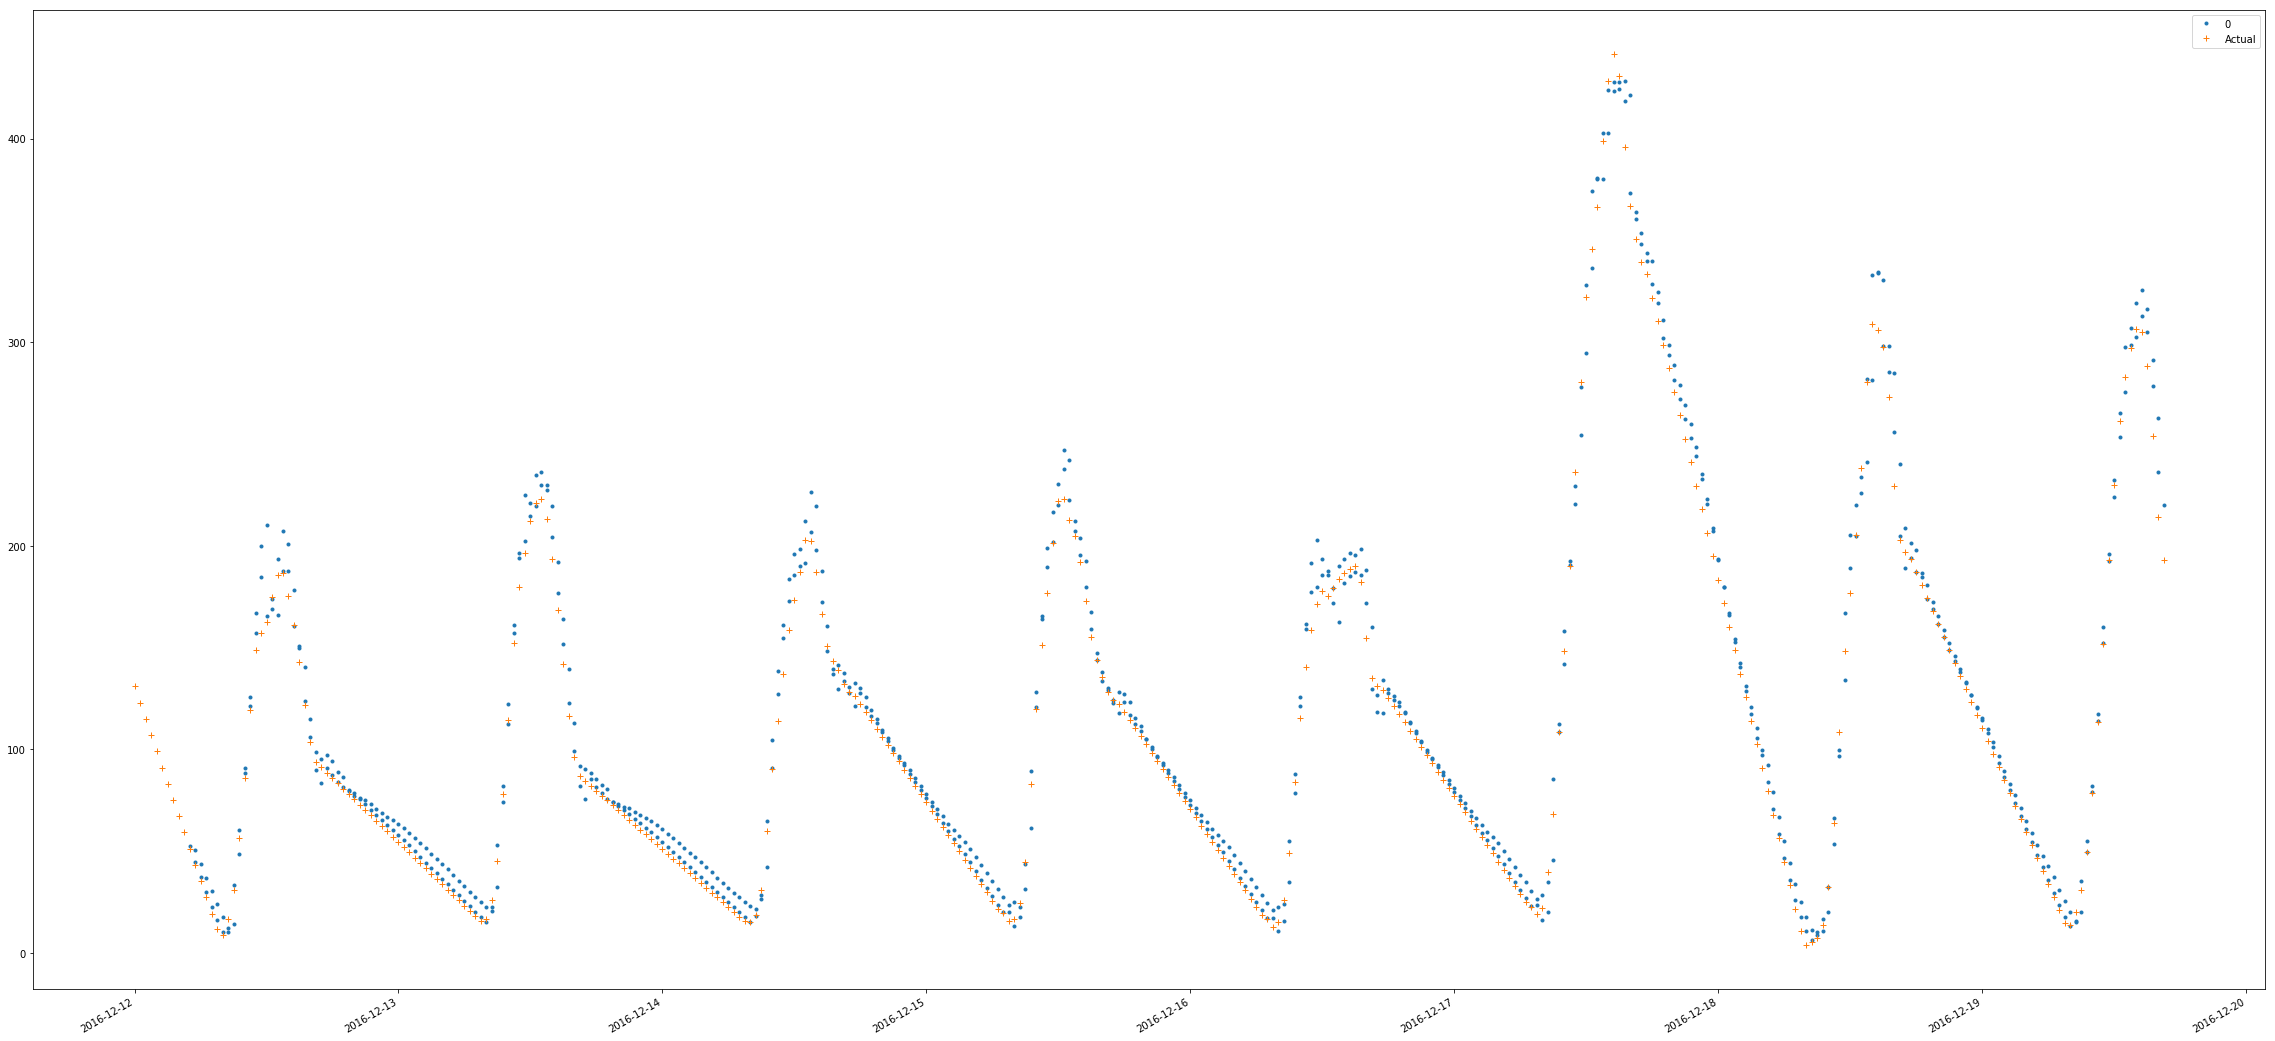

In [16]:
evaluate_model_plot(model, eval_set, n, m)